#  Use the dataset from TFRecord files to build and train a model

## Import all the necessary libraries

In [1]:
import os
import glob
from datetime import datetime

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

%matplotlib inline

tf.__version__

'2.0.0-beta1'

## Load the `tf.data.Dataset` from TFRecord files

In [2]:
raw_train_dataset = tf.data.TFRecordDataset('images.tfrecord')
raw_train_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## Parse the dataset

In [3]:
for raw_train_data in raw_train_dataset.take(-1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    print(example)

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 600
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\341\000$Exif\000\000II*\000\010\000\000\000\001\000\230\202\002\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\377\354\000\021Ducky\000\001\000\004\000\000\000<\000\000\377\341\003\224http://ns.adobe.com/xap/1.0/\000<?xpacket begin=\"\357\273\277\" id=\"W5M0MpCehiHzreSzNTczkc9d\"?> <x:xmpmeta xmlns:x=\"adobe:ns:meta/\" x:xmptk=\"Adobe XMP Core 5.3-c011 66.145661, 2012/02/06-14:56:27        \"> <rdf:RDF xmlns:rdf=\"http://www.w3.org/1999/02/22-rdf-syntax-ns#\"> <rdf:Description rdf:about=\"\" xmlns:xmpMM=\"http://ns.adobe.com/xap/1.0/mm/\" xmlns:stRef=\"http://ns.adobe.com/xap/1.0/sType/ResourceRef#\" xmlns:dc=\"http://purl.org/dc/elements/1.1/\" xmlns:xmp=\"http://ns.adobe.com/xap/

In [4]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def parse_tf_example(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)

    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    x_train = tf.image.resize(x_train, (416, 416))
    x_train /= 255.

    lebel = parsed_example['label']
    y_train = lebel
    
    return x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset shapes: ((416, 416, 3), ()), types: (tf.float32, tf.int64)>

### Recover the images from the TFRecord file:

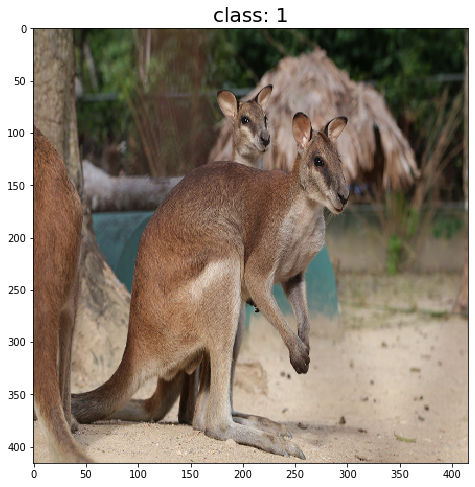

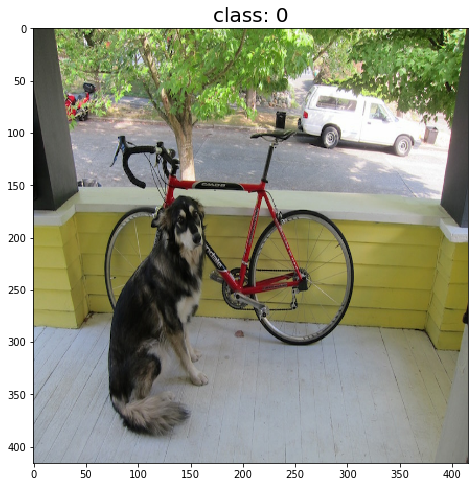

In [5]:
for x_train, y_train in train_dataset:
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(x_train.numpy())
    ax1.set_title('class: {}'.format(y_train), fontsize=20)

In [6]:
num_epochs = 10

train_ds = train_dataset.shuffle(buffer_size=10000).batch(2).repeat(num_epochs)
train_ds

<RepeatDataset shapes: ((None, 416, 416, 3), (None,)), types: (tf.float32, tf.int64)>

In [8]:
for batch, (x, y) in enumerate(train_ds):
    print(batch, x.shape, y)

0 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
1 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
2 (2, 416, 416, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
3 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
4 (2, 416, 416, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
5 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
6 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
7 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
8 (2, 416, 416, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
9 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)


In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'])

In [11]:
model.fit(train_ds, epochs=num_epochs)

Epoch 1/10


W1001 18:25:46.460961 139650930882368 deprecation.py:323] From /home/kaka/opt/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 1s 104ms/step - loss: 7.4213 - accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 0s 24ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 0s 23ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 0s 22ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 8/10
10/10 [==============================] - 0s 23ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 9/10
10/10 [==============================] - 0s 22ms/step - loss: 8.0590 - accuracy: 0.5000
Epoch 10/10
10/10 [==============================] - 0s 23ms/step - loss: 8.0590 - accuracy: 0.5000
